In [43]:
import numpy as np 
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

df_data_org = pd.read_json("./data/test.json", lines=True)
df_data_org.head()

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0


# Feature Engineering for `Score`

user가 명시적으로 남기는 `Score` 데이터가 없으므로, 선택 기록을 바탕으로 `Score`를 추정.
추정된 `Score`를 가지고 다음과 같이 진행.
1. Item별로 유사한 평가를 가지고 있는 user의 segements를 분류.
2. 나눠진 segements안에서 item의 평균 평점을 이용해, 같은 seg내 user에게 미경험 item을 추천.
3. 경험된 정도의 유사도 -> cosine similarity
4. 경험 중 선택율 -> euclidean similarity

## Filtering data

In [125]:
df_data = df_data_org.copy()
df_data

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0
...,...,...,...,...
96899,96899,67,1680,0
96900,96900,67,1943,0
96901,96901,67,1943,0
96902,96902,67,267,0


In [140]:
def get_count(value):
    res = dict()
    res['apply_cnt'] = value['id'].count()
    res['join_cnt'] = value['join'].sum()
    res['ratio'] = res['join_cnt'] / res['apply_cnt']
    return pd.Series(res, index=res.keys())

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_count)
df_grouped.reset_index(inplace=True)

In [151]:
def make_group(value):
    # res = dict()
    # res['item_id'] = value['item_id']
    # res['join_cnt'] = value['join_cnt']
    # res['ratio'] = value['ratio']
    # return pd.Series(res, index=res.keys())
    value.pop('user_id')
    res = value.to_dict(orient='records')
    return pd.Series({"data":res}, index='data')

df_grouped.groupby(['user_id']).apply(make_group)

TypeError: Index(...) must be called with a collection of some kind, 'data' was passed

In [132]:
df_grouped.to_dict(orient='index')

{(0, 0): {'apply_cnt': 3.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 1): {'apply_cnt': 3.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 2): {'apply_cnt': 2.0, 'join_cnt': 1.0, 'ratio': 0.5},
 (0, 3): {'apply_cnt': 8.0, 'join_cnt': 1.0, 'ratio': 0.125},
 (0, 7): {'apply_cnt': 5.0, 'join_cnt': 1.0, 'ratio': 0.2},
 (0, 8): {'apply_cnt': 1.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 10): {'apply_cnt': 8.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 11): {'apply_cnt': 8.0, 'join_cnt': 6.0, 'ratio': 0.75},
 (0, 12): {'apply_cnt': 2.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 13): {'apply_cnt': 2.0, 'join_cnt': 1.0, 'ratio': 0.5},
 (0, 15): {'apply_cnt': 1.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 16): {'apply_cnt': 7.0, 'join_cnt': 2.0, 'ratio': 0.2857142857142857},
 (0, 18): {'apply_cnt': 2.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 19): {'apply_cnt': 7.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 20): {'apply_cnt': 4.0, 'join_cnt': 1.0, 'ratio': 0.25},
 (0, 23): {'apply_cnt': 2.0, 'join_cnt': 0.0, 'ratio': 0.0},
 (0, 30): {

In [127]:
df_grouped['ratio'] = df_grouped['join_cnt'] / df_grouped['apply_cnt']
df_grouped

,user_id,item_id,apply_cnt,join_cnt,ratio
0,0,0,3,0,0.000
1,0,1,3,0,0.000
2,0,2,2,1,0.500
3,0,3,8,1,0.125
4,0,7,5,1,0.200
...,...,...,...,...,...
28557,69,1930,1,0,0.000
28558,69,1931,3,0,0.000
28559,69,1932,1,0,0.000
28560,69,1935,2,0,0.000


In [ ]:
def cosine_similarity(target_user:int, check_user:int, data:pd.DataFrame):
    target

In [110]:
def get_experienced_items(value):
    res = dict()
    res['items'] = value['item_id'].unique()
    res['items_count'] = len(res['items'])
    return pd.Series(res, index=res.keys())
    
df_data = df_data.groupby('user_id').apply(get_experienced_items).reset_index()
df_data

,user_id,items,items_count
0,0,"[0, 1, 2, 3, 7, 10, 11, 12, 13, 15, 16, 18, 20...",134
1,1,"[0, 3, 205]",3
2,2,[1],1
3,3,"[3, 34, 51, 52, 14, 21, 59, 66, 58, 25, 73, 10...",303
4,4,"[4, 5, 6, 7, 8, 9, 13, 14, 16, 17, 25, 30, 33,...",807
...,...,...,...
65,65,"[537, 917, 622, 830, 229]",5
66,66,"[1838, 1491, 1682, 172, 738, 1723, 247, 817, 8...",381
67,67,"[523, 738, 700, 405, 1365, 1356, 1844, 1001, 1...",625
68,68,"[125, 767, 1495, 886, 320, 1682, 1368, 462, 18...",440


In [112]:
dict_data = dict(zip(df_data['user_id'], df_data['items']))
dict_data

{0: array([  0,   1,   2,   3,   7,  10,  11,  12,  13,  15,  16,  18,  20,
         23,  19,  33,  35,  34,  36,  41,  42,  44,  53,  55,  59,  61,
         63,  64,  58,  66,  73,  74,  75,  77,  83,  38,  93,  94,  96,
        118, 259, 208, 103,  56, 260, 175, 258,  60, 263, 220, 245,  62,
        265, 256, 229, 234, 257, 241, 238, 267,  37, 219, 181, 269, 149,
         71, 243, 273, 246,  57,  68, 125, 228, 113,  43,  84, 188, 172,
         40, 286, 282, 117, 289,   8, 291, 292, 294, 296, 300, 301, 305,
        311, 312, 251, 209, 315, 316, 317, 318, 319, 324, 325, 327, 328,
        329, 183, 247, 331, 332, 104, 333,  30, 334, 335, 336, 337, 293,
        340, 341, 342, 343, 344, 345, 348, 349, 350, 203, 233, 352, 351,
         70, 193, 372, 330], dtype=int64),
 1: array([  0,   3, 205], dtype=int64),
 2: array([1], dtype=int64),
 3: array([   3,   34,   51,   52,   14,   21,   59,   66,   58,   25,   73,
          10,   55,   74,   71,   41,    4,   77,   79,   33,   82,    7,
   

In [120]:
# def get_cosine_similarity(a, b):
#     return np.dot(a, b) /( np.linalg.norm(a)*np.linalg.norm(b))

def get_cosine_similarity(target_user:list, check_user:list):
    target = list()
    check = list()
    total = set(list(target_user).__add__(list(check_user)))
    for idx in total:
        if idx in target_user:
            target.append(1)
        else:
            target.append(0)
        if idx in  check_user:
            check.append(1)
        else:
            check.append(0)
    print(f"total: {total}")
    print(f"target: {target}")
    print(f"check: {check}")

    return np.dot(target,check) /( np.linalg.norm(target)*np.linalg.norm(check))

get_cosine_similarity(dict_data[0],dict_data[3])

total: {0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 70, 71, 73, 74, 75, 77, 79, 82, 83, 84, 87, 88, 93, 94, 96, 97, 103, 104, 109, 112, 113, 114, 115, 117, 118, 122, 123, 124, 125, 126, 127, 133, 134, 137, 139, 149, 164, 169, 171, 172, 175, 181, 183, 184, 185, 188, 190, 193, 203, 206, 208, 209, 212, 215, 219, 220, 222, 224, 228, 229, 233, 234, 238, 241, 243, 245, 246, 247, 251, 254, 256, 257, 258, 259, 260, 263, 265, 266, 267, 269, 273, 282, 286, 289, 291, 292, 293, 294, 296, 300, 301, 305, 306, 307, 311, 312, 315, 316, 317, 318, 319, 320, 322, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 354, 361, 363, 368, 371, 372, 381, 386, 391, 392, 395, 400, 403, 408, 410, 414, 416, 420, 436, 437, 438, 445, 447, 453, 461, 462, 465, 469, 47

0.2431769273171488

In [123]:
get_cosine_similarity([0,1,2,8,9,10], [3,4,5,6,7,10])

total: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
target: [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
check: [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]


0.16666666666666669

In [18]:
def get_count(value):
    res = dict()
    res['apply_cnt'] = value['id'].count()
    res['join_cnt'] = value['join'].sum()
    return pd.Series(res, index=res.keys())

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_count)
df_grouped.reset_index(inplace=True)

In [19]:
df_grouped['ratio'] = df_grouped['join_cnt'] / df_grouped['apply_cnt']
df_grouped

,user_id,item_id,apply_cnt,join_cnt,ratio
0,0,0,3,0,0.000
1,0,1,3,0,0.000
2,0,2,2,1,0.500
3,0,3,8,1,0.125
4,0,7,5,1,0.200
...,...,...,...,...,...
28557,69,1930,1,0,0.000
28558,69,1931,3,0,0.000
28559,69,1932,1,0,0.000
28560,69,1935,2,0,0.000


In [ ]:
def get_cosine_sim(target_user_id:int, check_user_id:int, data:pd.DataFrame):
    target_user_exp_items = data.loc[data['user_id']==target_user_id, ['user_id', 'item_id']]
    

In [35]:
tdf = pd.get_dummies(df_grouped[['user_id', 'item_id']], prefix =None, columns=["item_id"]).groupby('user_id').sum().reset_index()

In [45]:
cosine_sim = cosine_similarity(tdf, tdf)
cosine_sim

array([[1.        , 0.08638684, 0.03863337, ..., 0.06523205, 0.03277665,
        0.04409137],
       [0.08638684, 1.        , 0.4472136 , ..., 0.4684513 , 0.47778451,
        0.48912803],
       [0.03863337, 0.4472136 , 1.        , ..., 0.83799115, 0.85468692,
        0.87497882],
       ...,
       [0.06523205, 0.4684513 , 0.83799115, ..., 1.        , 0.96346221,
        0.95142344],
       [0.03277665, 0.47778451, 0.85468692, ..., 0.96346221, 1.        ,
        0.96049197],
       [0.04409137, 0.48912803, 0.87497882, ..., 0.95142344, 0.96049197,
        1.        ]])

In [46]:
cosine_sim.shape

(70, 70)

<AxesSubplot: >

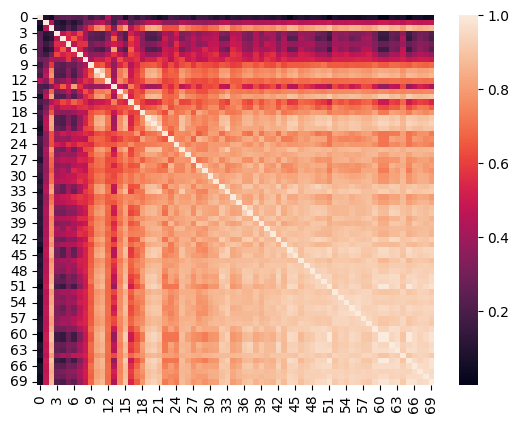

In [47]:
sns.heatmap(cosine_sim)

In [56]:
# [(idx, x) for idx, x in enumerate(cosine_sim[60])]
tmp = list(filter(lambda x: x[1]>0.9, enumerate(cosine_sim[60])))
tmp.sort(key=lambda x: x[1], reverse=True)

[(60, 0.9999999999999997),
 (65, 0.9983002018024484),
 (61, 0.9975512024022484),
 (51, 0.9935571864929033),
 (69, 0.9778790148370564),
 (63, 0.9625954978205482),
 (66, 0.9588456206154263),
 (44, 0.9563650695950073),
 (68, 0.9552108942710641),
 (55, 0.9494974005932535),
 (49, 0.9467539902806436),
 (45, 0.9459550592550647),
 (62, 0.9456018024674061),
 (20, 0.9438542844219546),
 (50, 0.9412836707704886),
 (56, 0.9402376281633257),
 (59, 0.9372908267042498),
 (67, 0.9372601327104751),
 (53, 0.9298243255661697),
 (33, 0.9262176333364818),
 (54, 0.9208389472419011),
 (19, 0.9197950784291601),
 (15, 0.9172883464035511),
 (48, 0.9127221384669593),
 (21, 0.9116208929254445),
 (42, 0.907007711501721),
 (57, 0.9052660221952197),
 (47, 0.9045972400255735)]

In [72]:
tt = tdf.loc[tdf['user_id'].isin([60,65])]


In [73]:
list(filter(lambda x: x>1, tt.sum(axis='rows')))

[125]

In [75]:
tt = tt.T
tt

,60,65
user_id,60,65
item_id_0,0,0
item_id_1,0,0
item_id_2,0,0
item_id_3,0,0
...,...,...
item_id_1957,0,0
item_id_1958,0,0
item_id_1959,0,0
item_id_1960,0,0


In [101]:
def check_same(value):
    value = list(value)
    if value[0] == value[1]:
        return 1
    else:
        return 0
tt['Bool'] = tt.apply(check_same, axis=1)
tt

,60,65,Bool
user_id,60,65,0
item_id_0,0,0,1
item_id_1,0,0,1
item_id_2,0,0,1
item_id_3,0,0,1
...,...,...,...
item_id_1957,0,0,1
item_id_1958,0,0,1
item_id_1959,0,0,1
item_id_1960,0,0,1


In [102]:
tt['sum'] = tt[60]+tt[65]
tt

,60,65,Bool,sum
user_id,60,65,0,125
item_id_0,0,0,1,0
item_id_1,0,0,1,0
item_id_2,0,0,1,0
item_id_3,0,0,1,0
...,...,...,...,...
item_id_1957,0,0,1,0
item_id_1958,0,0,1,0
item_id_1959,0,0,1,0
item_id_1960,0,0,1,0


In [105]:
tt.loc[
    (tt['Bool']!=1) & (tt['sum']>0)
]

,60,65,Bool,sum
user_id,60,65,0,125
item_id_7,1,0,0,1
item_id_16,1,0,0,1
item_id_74,1,0,0,1
item_id_181,1,0,0,1
item_id_219,1,0,0,1
item_id_224,1,0,0,1
item_id_229,0,1,0,1
item_id_246,1,0,0,1
item_id_407,1,0,0,1
